0.22800000000000017


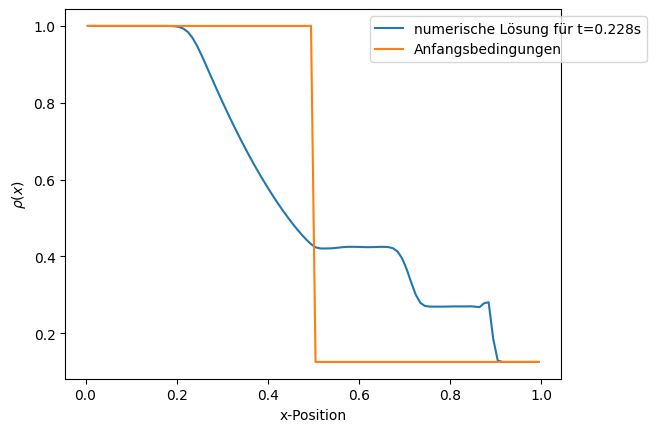

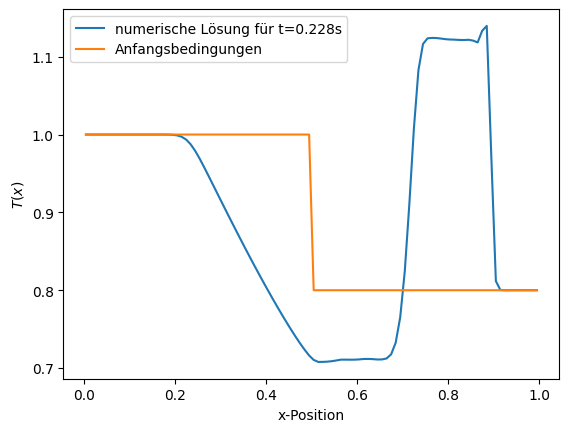

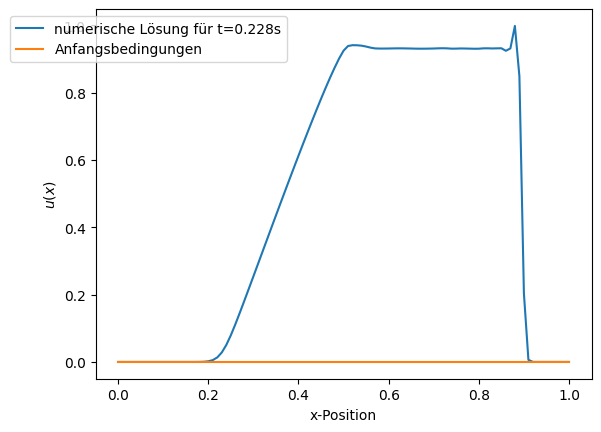

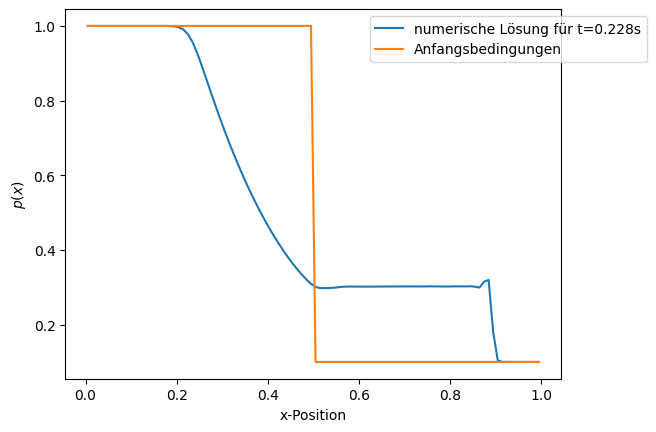

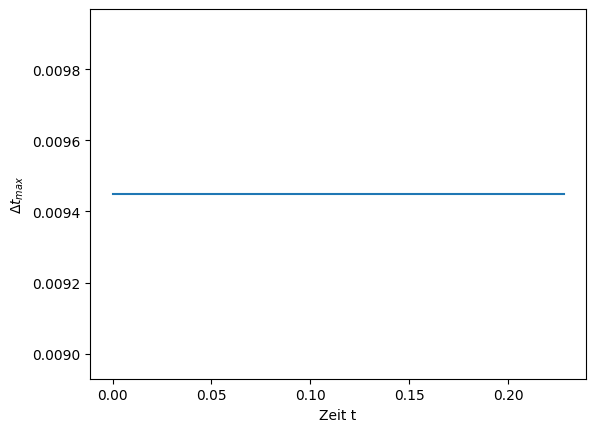

In [2]:
import numpy as np
import matplotlib.pyplot as plt
N_x = 100

t_max = 0.228
frame = 1
delta_x = frame/(N_x)
v = 1
u_start = np.zeros((N_x+3))

delta_t = 0.001
x_0 = 0.5
d_start = np.zeros((N_x+4))
d_start[:int((x_0)//delta_x+3)]=1
d_start[int((x_0)//delta_x+3):]=0.125
e_start = np.zeros((N_x+4))
e_start[:int((x_0)//delta_x+3)]=2.5
e_start[int((x_0)//delta_x+3):]=2

g = 0.4


def delta_d(d):
    
    result =2*(d[2:]-d[1:-1])*(d[1:-1]-d[0:-2])
    np.place(result,result<0,[0])
    denumerator= d[2:]-d[0:-2]
    # hier ersetze ich nullen durch eine 1 um nicht durch 0 zu teilen. result ist an dieser stelle sowieso 0, da für d_(j+1)=d_(j-1) sowieso die 
    # Stelle in 'result' kleiner 0 ist. (siehe van Leer Schema)
    np.place(denumerator,denumerator==0,[1])
    return result/denumerator

def mittel(d):
    return (d[0:-1]+d[1:])/2
    

def d_adv(d,ddelt,u):
    
    
    adv_p =d[1:-2]+(1-u[1:-1]*delta_t/delta_x)/2*ddelt[0:-1]
    np.place(adv_p,u_iter[1:-1]<=0,[0])
    adv_m = d[2:-1]-(1+u[1:-1]*delta_t/delta_x)/2*ddelt[1:]
    np.place(adv_m,u_iter[1:-1]>0,[0])
    return adv_m+adv_p

def u_adv(d,ddelt):
    
    
    adv_p =d[1:-2]+(1-mittel(d)[1:-1]*delta_t/delta_x)/2*ddelt[0:-1]
    np.place(adv_p,u_iter[1:-2]<=0,[0])
    adv_m = d[2:-1]-(1+mittel(d)[1:-1]*delta_t/delta_x)/2*ddelt[1:]
    np.place(adv_m,u_iter[1:-2]>0,[0])
    return adv_m+adv_p
    
def d_int(d,u,dadv):
    
    return d[2:-2]-delta_t/delta_x*(dadv[1:]*u[2:-1]-dadv[0:-1]*u[1:-2])



def u_int(u,d,uadv,dadv,d_old):
    return (u[2:-2]*mittel(d_old)[2:-2]-delta_t/delta_x*(mittel(dadv*u[1:-1])[1:]*uadv[1:]-mittel(dadv*u[1:-1])[:-1]*uadv[0:-1]))/mittel(d)[2:-2]

def e_int(e,d_old,d,dadv,eadv):
    return (e[2:-2]*d_old[2:-2]-delta_t/delta_x*(dadv[1:]*u_iter[2:-1]*eadv[1:]-dadv[0:-1]*u_iter[1:-2]*eadv[0:-1]))/d[2:-2]

def u_2nd_int():
    return u_iter[2:-2]-delta_t/mittel(d_iter)[2:-2]*(g*d_iter[3:-2]*e_iter[3:-2]-g*d_iter[2:-3]*e_iter[2:-3])/delta_x

def e_2nd_int():
    return e_iter[2:-2]-delta_t*g*d_iter[2:-2]*e_iter[2:-2]/d_iter[2:-2]*(u_old[2:-1]-u_old[1:-2])/delta_x

# ich habe Gitterplatzindex a und b gegenteilig zum Skript definiert. a dichte,energie; b geschwindigkeit
def rb_a(x):
    endresult = np.zeros(N_x+4)
    endresult[2:-2] = x
    endresult[0] = endresult[3]
    endresult[1] = endresult[2]
    endresult[-2] = endresult[-3]
    endresult[-1] = endresult[-4]
    return endresult

def rb_b(x):
    endresult = np.zeros(N_x+3)
    endresult[2:-2] = x
    endresult[0] = endresult[2]
    endresult[-1] = endresult[-3]
    return endresult

d_start = rb_a(d_start[2:-2])
e_start = rb_a(e_start[2:-2])


t_sum = [0]
d_iter= d_start
u_iter = u_start
e_iter = e_start
time = []
sound_speed= (0.4*1.4*e_iter)**(1/2)
time.append(sum(t_sum))
time_delta = [max(0.01/(sound_speed[1:]+u_iter))]
# ddelt = np.zeros(N_x+2)
while sum(t_sum)<t_max:
    # advection
    t_sum.append(delta_t)
    ddelt = delta_d(d_iter)
    dadv = d_adv(d_iter,ddelt,u_iter)
    d_old = d_iter
    d_iter = rb_a(d_int(d_iter,u_iter,dadv))
    udelt = delta_d(u_iter)
    uadv = u_adv(u_iter,udelt)
    edelt = delta_d(e_iter)
    eadv = d_adv(e_iter,edelt,u_iter)
    e_iter = rb_a(e_int(e_iter,d_old,d_iter,dadv,eadv))
    u_iter = rb_b(u_int(u_iter,d_iter,uadv,dadv,d_old))
    # Kräfte Druck
    u_old = u_iter
    u_iter = rb_b(u_2nd_int())
    e_iter = rb_a(e_2nd_int())
    # das folgende ist nur zur Überwachung von Delta_t_max (siehe Protokoll)
    sound_speed= (0.4*1.4*e_iter)**(1/2)
    time.append(sum(t_sum))
    time_delta.append(max(0.01/(sound_speed[1:]+u_iter)))


print(sum(t_sum))
T = g*e_iter
p = g *d_iter*e_iter

T_start = g*e_start
p_start = g *d_start*e_start

pos_mark = np.arange(N_x+1)
pos_b = pos_mark*delta_x
pos_a = delta_x/2+pos_mark[:-1]*delta_x

fig, ax = plt.subplots(1,1)
ax.plot(pos_a,d_iter[2:-2])
ax.plot(pos_a,d_start[2:-2]) 
ax.set_xlabel('x-Position') 
ax.set_ylabel(r'$\rho(x)$')
ax.legend(['numerische Lösung für t=0.228s','Anfangsbedingungen'],bbox_to_anchor=(0.6,1))

fig2, ax2 = plt.subplots(1,1)
ax2.plot(pos_a,T[2:-2])
ax2.plot(pos_a,T_start[2:-2])  
ax2.set_xlabel('x-Position') 
ax2.set_ylabel(r'$T(x)$')
ax2.legend(['numerische Lösung für t=0.228s','Anfangsbedingungen'])

fig3, ax3 = plt.subplots(1,1)
ax3.plot(pos_b,u_iter[1:-1])
ax3.plot(pos_b,u_start[1:-1])  
ax3.set_xlabel('x-Position') 
ax3.set_ylabel(r'$u(x)$')
ax3.legend(['numerische Lösung für t=0.228s','Anfangsbedingungen'],bbox_to_anchor=(0.4,1))

fig4, ax4= plt.subplots(1,1)
ax4.plot(pos_a,p[2:-2])
ax4.plot(pos_a,p_start[2:-2]) 
ax4.set_xlabel('x-Position') 
ax4.set_ylabel(r'$p(x)$')
ax4.legend(['numerische Lösung für t=0.228s','Anfangsbedingungen'],bbox_to_anchor=(0.6,1))

fig5, ax5= plt.subplots(1,1)
ax5.plot(time,time_delta)
ax5.set_xlabel('Zeit t') 
ax5.set_ylabel(r'$\Delta{t}_{max}$')

plt.show()
